In [9]:
import os
import sys
import time
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Tuple, List, Dict, Callable, Iterable
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    cross_validate
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score
)

sys.path.append(os.path.join('..', 'src'))

from tweets_sentiment_analysis.core.preprocessing import TextPreprocessor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
plt.style.use('seaborn')

In [3]:
credentials_file = os.path.abspath(os.path.join('..', 'credentials.yaml'))
with open(credentials_file, 'r') as f:
    credentials = yaml.safe_load(f)

storage_options = {
    'key': credentials['aws']['access_key'],
    'secret': credentials['aws']['secret_access_key']
}

In [4]:
partition_uri = f's3://{credentials["aws"]["bucket"]}/reviews/reviews_partition_1.csv'
partition = pd.read_csv(
    partition_uri,
    compression='gzip',
    storage_options=storage_options,
    usecols=['text', 'rating', 'total_votes']
)
partition['positive'] = partition['rating'] > 5
partition = partition[~partition['rating'].isna()].drop('rating', axis=1)

mem = partition.memory_usage(deep=True).sum()/1024/1024
print('Number of reviews:', len(partition))
print(f'Memory usage: {mem:.1f} Mb')
partition.head()

Number of reviews: 220873
Memory usage: 249.0 Mb


,text,total_votes,positive
0,"Chucky (the murderous doll from ""Child's Play""...",40,True
1,"They obviously made ""Bride of Chucky"" with the...",20,True
2,Well my opinion has changed for this one becau...,22,True
3,Clever is the word that comes to mind when I t...,15,True
4,Realizing he needs to turn back into human for...,15,True


In [5]:
partition_sample = (
    partition
    .sort_values(['positive', 'total_votes'])
    .groupby('positive')
    .tail(20000)
)

preprocessor = TextPreprocessor()
partition_sample['processed_text'] = partition_sample['text'].apply(preprocessor._transform)
partition_sample.head()

,text,total_votes,positive,processed_text
132565,"Uhm, no. This was just cartoonish and silly. I...",14,False,uhm cartoonish silly certainly aim young demog...
132831,The final twist will probably be the final str...,14,False,final twist probably final straw manage weathe...
132847,Visually 'Renaissance' proves to be an interes...,14,False,visually renaissance prove interesting time br...
132867,I kept waiting for these great graphics as in ...,14,False,keep wait great graphic reviewer comment far t...
133035,I'll preface this review by saying I'm a strai...,14,False,preface review say straight guy obviously know...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    partition_sample['processed_text'],
    partition_sample['positive'],
    train_size=0.8
)

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=2000)
tfidf_mat = vectorizer.fit_transform(X_train)
tfidf_mat.shape

(32000, 2000)

# Comparison of models with default hyperparameters

In [12]:
models = {
    'logreg': LogisticRegression(max_iter=1000),
    'tree': DecisionTreeClassifier(max_depth=5),
    'rf': RandomForestClassifier(max_depth=5),
    'knn': KNeighborsClassifier(),
    'nb': MultinomialNB()
}
models_results = {}
for model_nm, model in models.items():
    print(f'Cross-validating {model_nm} model')
    s = time.time()
    models_results[model_nm] = cross_validate(
        model,
        tfidf_mat,
        y_train,
        scoring=['accuracy', 'f1'],
        return_train_score=True
    )
    e = time.time()
    print(f'Completed in {(e - s):.1f} seconds')

Cross-validating logreg model
Completed in 1.8 seconds
Cross-validating tree model
Completed in 4.4 seconds
Cross-validating rf model
Completed in 9.1 seconds
Cross-validating knn model
Completed in 202.9 seconds
Cross-validating nb model
Completed in 0.2 seconds


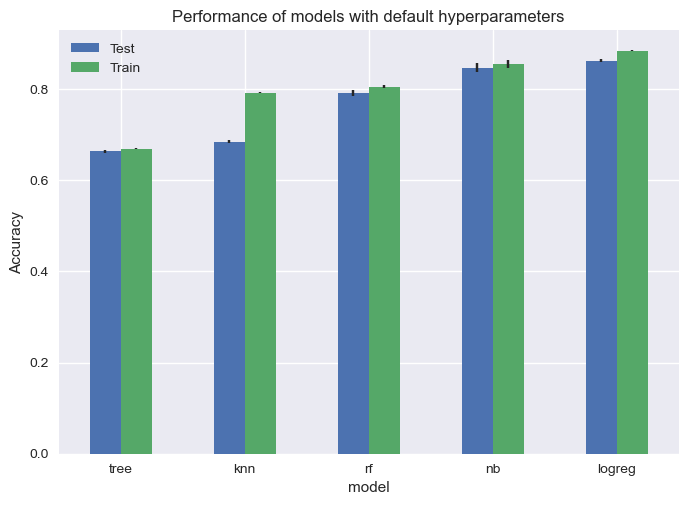

In [32]:
cv_df = pd.DataFrame({
    'model': models_results.keys(),
    'test_accuracy_mean': [
        res['test_accuracy'].mean()
        for res in models_results.values()
    ],
    'test_accuracy_std': [
        res['test_accuracy'].std()
        for res in models_results.values()
    ],
    'train_accuracy_mean': [
        res['train_accuracy'].mean()
        for res in models_results.values()
    ],
    'train_accuracy_std': [
        res['train_accuracy'].std()
        for res in models_results.values()
    ]
})
cv_df_mean = (
    cv_df[['model', 'test_accuracy_mean', 'train_accuracy_mean']]
    .set_index('model')
    .sort_values('test_accuracy_mean', ascending=True)
)
cv_df_mean.plot(
    kind='bar',
    ylabel='Accuracy',
    title='Performance of models with default hyperparameters',
    yerr=[cv_df['test_accuracy_std'], cv_df['train_accuracy_std']]
)
plt.legend(labels=['Test', 'Train'], loc='best')
plt.xticks(rotation=0)
plt.show()

In [63]:
tfidf = TfidfVectorizer()
tfidf_mat = tfidf.fit_transform(X_train)

pca_transformer = TruncatedSVD(n_components=100)
pca_transformer.fit(tfidf_mat)

TruncatedSVD(n_components=100)

In [85]:
pipe = Pipeline([
    ('tf-idf', TfidfVectorizer(use_idf=False, max_features=500)),
    ('logreg', LogisticRegression(max_iter=1000))
])
pipe.fit(X_train, y_train)
pipe_prediction = pipe.predict(X_val)
pipe_report = classification_report(y_val, pipe_prediction)
print(pipe_report)

              precision    recall  f1-score   support

       False       0.83      0.81      0.82      1977
        True       0.82      0.84      0.83      2023

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



In [156]:
pipe_svc = Pipeline([
    ('tf-idf', TfidfVectorizer(use_idf=False, max_features=500)),
    ('logreg', SVC(kernel='rbf'))
])

In [160]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe_svc, X_train[:5000], y_train[:5000], cv=5, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   6.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] END .................................................... total time=   6.1s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.2s
[CV] END .................................................... total time=   6.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.8s finished


In [136]:
train_size, train_score, val_score = learning_curve(
    pipe, X_train, y_train, train_sizes=np.linspace(0.2, 1, 100), scoring='accuracy', verbose=2
)

[learning_curve] Training set sizes: [ 2560  2663  2766  2870  2973  3077  3180  3284  3387  3490  3594  3697
  3801  3904  4008  4111  4214  4318  4421  4525  4628  4732  4835  4938
  5042  5145  5249  5352  5456  5559  5663  5766  5869  5973  6076  6180
  6283  6387  6490  6593  6697  6800  6904  7007  7111  7214  7317  7421
  7524  7628  7731  7835  7938  8042  8145  8248  8352  8455  8559  8662
  8766  8869  8972  9076  9179  9283  9386  9490  9593  9696  9800  9903
 10007 10110 10214 10317 10421 10524 10627 10731 10834 10938 11041 11145
 11248 11351 11455 11558 11662 11765 11869 11972 12075 12179 12282 12386
 12489 12593 12696 12800]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.6s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.8s
[CV] END ...................

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 17.9min finished


In [145]:
import numpy as np

def plot_learning_curve(
    train_size: np.array,
    train_score: np.ndarray,
    val_score: np.ndarray,
    metric_nm: str = 'Accuracy',
    title: str = 'Learning curve'
):
    train_score_mean = train_score.mean(axis=1)
    train_score_std = train_score.std(axis=1)
    val_score_mean = val_score.mean(axis=1)
    val_score_std = val_score.std(axis=1)
    plt.plot(train_size, train_score.mean(axis=1), label='Train score')
    plt.fill_between(
        train_size,
        train_score_mean - train_score_std,
        train_score_mean + train_score_std,
        alpha=0.1,
    )
    plt.plot(train_size, val_score.mean(axis=1), label='Validation score')
    plt.fill_between(
        train_size,
        val_score_mean - val_score_std,
        val_score_mean + val_score_std,
        alpha=0.1,
    )
    plt.legend(loc='best')
    plt.xlabel('Train size')
    plt.ylabel(metric_nm)
    plt.title(title)
    plt.show()

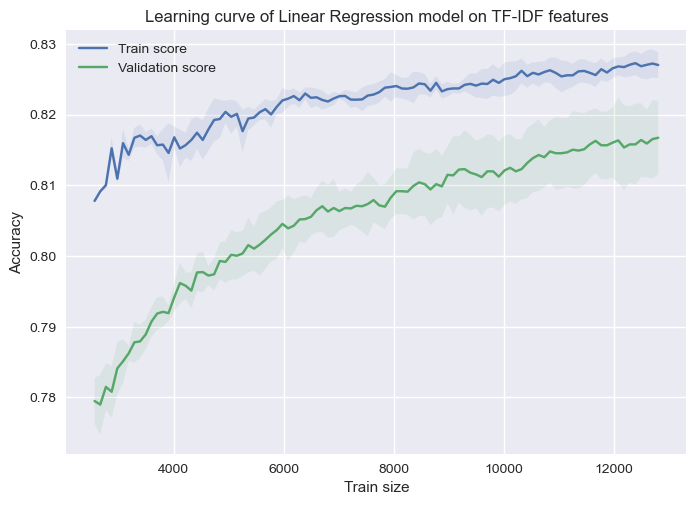

In [146]:
plot_learning_curve(
    train_size,
    train_score,
    val_score,
    title='Learning curve of Linear Regression model on TF-IDF features'
)